# Clustering t-SNE representations in figure 1c

1. Datasets - the ones shown in Scala et al.'s article, figure 1c. The t-SNE representations of CGE interneurons from Yao et al. and  Scala et al.
3. 2 clusterings for each dataset: each for broad cell families and the smaller cell families
4. Evaluation method: adjusted mutual information, Fowlkes-Mallows

Will use clustering methods in https://scikit-learn.org/stable/modules/clustering.html

In [1]:
import pickle
from collections import namedtuple
import numpy as np
import os.path
from sklearn.cluster import *
from preprocess_figdata import preprocess_figure_data
from plot_fig1c import plot_sidebyside
from misc_tools import le_family_names, ami_and_fmscore
from sklearn import preprocessing

import sys
sys.path.append('../')
import rnaseqTools

In [2]:
# load Yao et al.'s dataset for the Vip/Lamp5 cells
m1data = pickle.load(open('../../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))["viplamp"]

# load the study results of Scala et al.
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../../data/processed/rnaseq/m1.pickle', 'rb'))

#load transcriptomic type assignment from Scala et al.
ttypes = pickle.load(open('../../data/processed/rnaseq/ttypes.pickle', 'rb'))
subset = np.isin(ttypes['family'], ['Lamp5', 'Vip']) #mask to get vip/lamp5 cell info from m1

# load t-SNE representations of Yao et al.'s Vip/Lamp5 cells
Z = pickle.load(open('../../data/processed/rnaseq/10x-tsne-viplamp.pickle', 'rb')) 

In [3]:
# if the datasets are not preprocessed and put into pickle files yet, do it now
# UMIcnt_path = "../../data/clustering_datasets/viplamp_umi.pickle"
# exintex_path = "../../data/clustering_datasets/viplamp_exint.pickle"

# if (os.path.isfile(UMIcnt_path)==False) and (os.path.isfile(exintex_path)==False):
#     preprocess_figure_data(m1data['counts'], m1data['genes'], m1.exonCounts[subset,:], m1.intronCounts[subset,:], 
#                     m1.genes, m1.exonLengths, m1.intronLengths, UMI_fname=UMIcnt_path, 
#                     exint_fname=exintex_path)

In [4]:
# function for fitting all the scikit-learn models
def fit_all_sklearn(training_data, true_labels, n_clusters, file_path, random_state):
    """
    This function will fit the training data to all clustering methods in this webpage:
    https://scikit-learn.org/stable/modules/clustering.html
    
    The trained models will be saved in the specified file path.
    arguments n_clusters and random_state are for the clustering methods that have these parameters.
    """
    
    model_dict = {} # a dictionary that will contain all trained models
    
    print("Fitting k-means...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(training_data)
    model_dict["k-means"] = kmeans
    pickle.dump(kmeans, open(file_path + "k-means" + ".pickle", 'wb'))

    print("Fitting affinity propagation...")
    affinity = AffinityPropagation(random_state=random_state).fit(training_data)
    model_dict["affinity"] = affinity
    pickle.dump(affinity, open(file_path + "affinity"+".pickle", 'wb'))

    print("Fitting mean shift...")
    mean_shift = MeanShift().fit(training_data)
    model_dict["mean shift"] = mean_shift
    pickle.dump(mean_shift , open(file_path + "mean_shift" + ".pickle", 'wb'))

    print("Fitting spectral clustering...")
    spectral = SpectralClustering(n_clusters=n_clusters).fit(training_data)
    model_dict["spectral"] = spectral
    pickle.dump(spectral, open(file_path + "spectral" + ".pickle", 'wb'))

    print("Fitting agglomerative clustering...")
    agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(training_data)
    model_dict["agglomerative"] = agglo
    pickle.dump(agglo, open(file_path + "agglomerative" + ".pickle", 'wb'))

    print("Fitting DBSCAN...")
    dbscan = DBSCAN().fit(training_data)
    model_dict["dbscan"] = dbscan
    pickle.dump(dbscan, open(file_path + "dbscan"+".pickle", 'wb'))

    print("Fitting OPTICS...")
    optics = OPTICS().fit(training_data)
    model_dict["optics"] = optics
    pickle.dump(optics, open(file_path + "optics" + ".pickle", 'wb'))

    print("Fitting Birch...")
    birch = Birch(n_clusters=n_clusters).fit(training_data)
    model_dict["birch"] = birch
    pickle.dump(birch, open(file_path + "birch" + ".pickle", 'wb'))
    
    return model_dict

In [5]:
def print_results(model_dict,true_labels, Z, m1data): 
    """
    This function is for getting and displaying the prediction results.
    
    Z: the t-SNE representations for Yao et al.'s 15,511 cells
    m1data: Yao et al.'s dataset for the subroup "viplamp"
    """
    pred_dict = {} # dictionary to store the predictions
    score_dict = {} # dictionary to store the evaluation scores
    
    # print the adjusted mutual information and Fowlkes-Mallows score
    for  model_name, model in model_dict.items():
        scores={}
        print("-------------------------------"+model_name+"-------------------------------")
        pred = model.labels_
        scores["ami"],  scores["fms"] =  ami_and_fmscore(true_labels, pred) 

        pred_dict[model_name] = pred
        score_dict[model_name] = scores
    
    # plot clustering results with figure 1c
    for  model_name, pred  in pred_dict.items():
        plot_sidebyside(training_data, pred, Z, m1data, title=model_name)
    
    return pred_dict, score_dict

## Broad cell families

In [6]:
random_state = 0 # setting random state for models 
save = False # setting this too true will train and save the models, else it will load the models saved last time

### Yao et al.'s cells

Yao et al.'s data has 15,511 cells from three broad cell families, Vip, Lamp5, and Sncg. In figure 1c they are all expressed in 2-dimensional t-SNE representations.

In [7]:
n_clusters = 3 # the number of broad cell families is 3
training_data = Z
file_path = "./models/t-SNE/broad/Yao/" # file path to save or load models

In [8]:
# create broad cell family labels because Yao et al.'s data doesn't come with one
yao_family_names, yao_family_codes = le_family_names(m1data)

Family_labels:
Lamp5: [0]
Sncg: [1]
Vip: [2]


In [9]:
if save == True:
    model_dict_yao = fit_all_sklearn(training_data=Z, true_labels=yao_family_codes, n_clusters=n_clusters, 
                                 file_path=file_path, random_state=random_state)
else:
    model_dict_yao={}
    model_dict_yao["k-means"] = pickle.load(open(file_path + "k-means" + ".pickle", 'rb'))
    model_dict_yao["affinity"] = pickle.load(open(file_path + "affinity"+".pickle", 'rb'))
    model_dict_yao["mean shift"] = pickle.load(open(file_path + "mean_shift" + ".pickle", 'rb'))
    #model_dict_yao["spectral"] = pickle.load(open(file_path + "spectral" + ".pickle", 'rb'))
    #model_dict_yao["agglo"] = pickle.load(open(file_path + "agglomerative" + ".pickle", 'rb'))
    model_dict_yao["dbscan"] = pickle.load(open(file_path + "dbscan"+".pickle", 'rb'))
    model_dict_yao["optics"] = pickle.load(open(file_path + "optics" + ".pickle", 'rb'))
    model_dict_yao["birch"] = pickle.load(open(file_path + "birch" + ".pickle", 'rb'))

/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator AffinityPropagation from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MeanShift from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DBSCAN from version 0.23.1 when using version 0.24.2. This mig

-------------------------------k-means-------------------------------
Adjusted Mutual Info: 0.4434050321834581
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.656219406649552
(0: bad, 1: perfect)

-------------------------------affinity-------------------------------
Adjusted Mutual Info: -3.0499166806564216e-16
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.6609807000126934
(0: bad, 1: perfect)

-------------------------------mean shift-------------------------------
Adjusted Mutual Info: 0.4744960189181844
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.7442733871511906
(0: bad, 1: perfect)

-------------------------------dbscan-------------------------------
Adjusted Mutual Info: 0.16214404378967853
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.39058980536946397
(0: bad, 1: perfect)

-------------------------------optics-------------------------------
Adjusted Mutual Info: 0.1646784437943729
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.2991923559874163
(0: bad, 1: perfect)

--

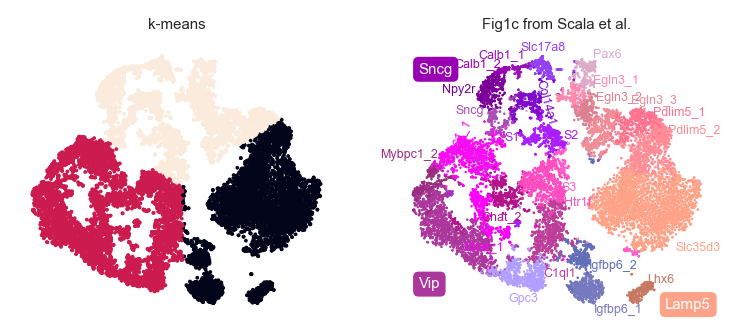

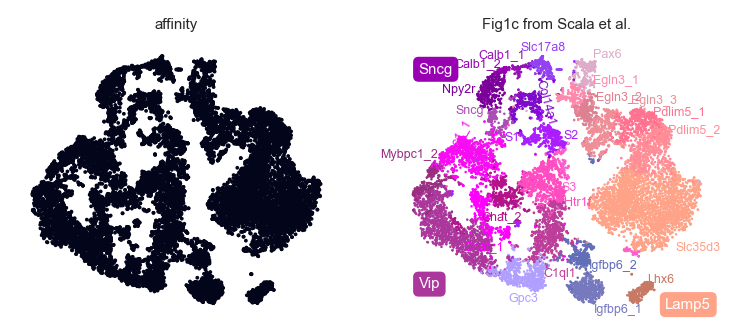

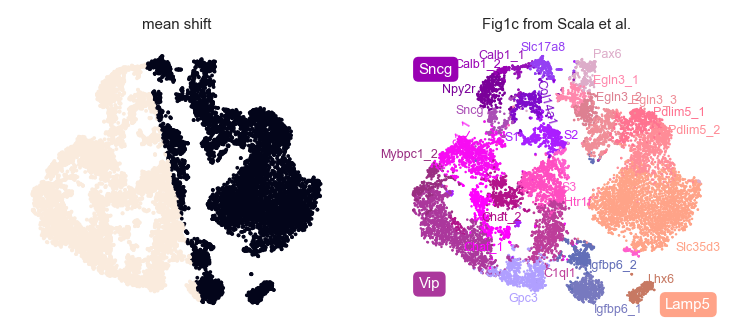

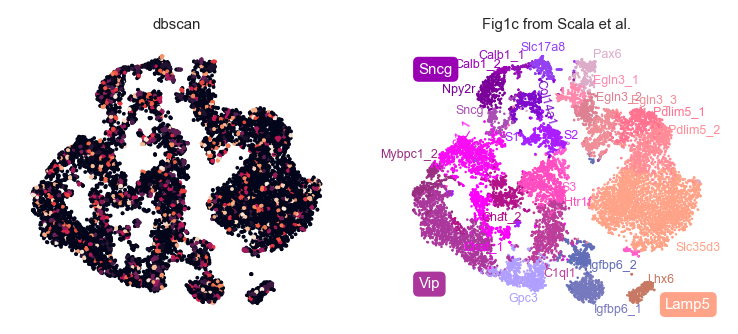

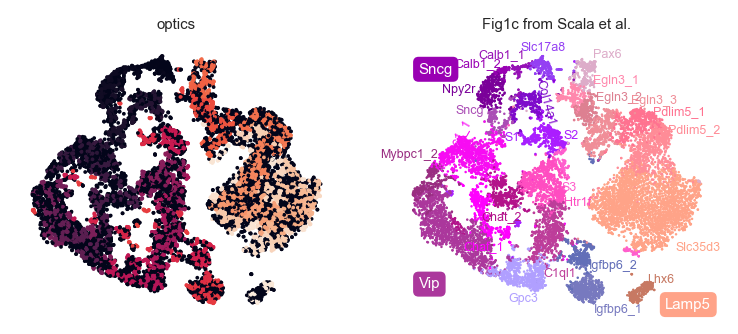

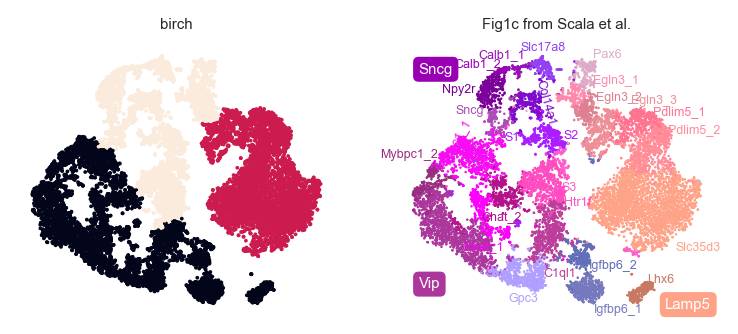

In [10]:
pred_yao, score_yao = print_results(model_dict_yao,true_labels=yao_family_codes, Z=Z, m1data=m1data)

### Scala et al.'s cells

Scala et al.'s data has 244 cells from broad cell families Vip and Lamp5, but not from Sncg. They explained that they did not have enough cells to run analyses on Sncg. Like Yao et al.'s cells, they are all expressed in 2-dimensional t-SNE representations in figure 1c.

In [11]:
# get estimated t-SNE representations
pos = rnaseqTools.map_to_tsne(m1data['counts'], m1data['genes'],
                              m1.exonCounts[subset,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[subset,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

Using a common set of 490 genes.


In [16]:
n_clusters = 2 # the number of broad cell families is 2
training_data = pos
file_path = "./models/t-SNE/broad/Scala/" # file path to save or load models
save = True

In [17]:
# get the family codes
le = preprocessing.LabelEncoder()
scala_family_names = ttypes['family'][subset]
scala_family_codes = le.fit_transform(scala_family_names)

print("Family_labels:")
for label in le.classes_:
    print(f"{label}: {le.transform(np.array(label).reshape(-1,))}")

Family_labels:
Lamp5: [0]
Vip: [1]


In [18]:
if save == True:
    model_dict_scala = fit_all_sklearn(training_data=pos, true_labels=scala_family_codes, n_clusters=n_clusters, 
                                 file_path=file_path, random_state=random_state)
else:
    model_dict_scala={}
    model_dict_scala["k-means"] = pickle.load(open(file_path + "k-means" + ".pickle", 'rb'))
    model_dict_scala["affinity"] = pickle.load(open(file_path + "affinity"+".pickle", 'rb'))
    model_dict_scala["mean shift"] = pickle.load(open(file_path + "mean_shift" + ".pickle", 'rb'))
    model_dict_scala["spectral"] = pickle.load(open(file_path + "spectral" + ".pickle", 'rb'))
    model_dict_scala["agglo"] = pickle.load(open(file_path + "agglomerative" + ".pickle", 'rb'))
    model_dict_scala["dbscan"] = pickle.load(open(file_path + "dbscan"+".pickle", 'rb'))
    model_dict_scala["optics"] = pickle.load(open(file_path + "optics" + ".pickle", 'rb'))
    model_dict_scala["birch"] = pickle.load(open(file_path + "birch" + ".pickle", 'rb'))

Fitting k-means...
Fitting affinity propagation...
Fitting mean shift...
Fitting spectral clustering...
Fitting agglomerative clustering...
Fitting DBSCAN...
Fitting OPTICS...
Fitting Birch...


-------------------------------k-means-------------------------------
Adjusted Mutual Info: 0.8738035557794
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.9694714749093685
(0: bad, 1: perfect)

-------------------------------affinity-------------------------------
Adjusted Mutual Info: 0.4219808839977985
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.4309548570159759
(0: bad, 1: perfect)

-------------------------------mean shift-------------------------------
Adjusted Mutual Info: 0.8500844744118852
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.9619263031052823
(0: bad, 1: perfect)

-------------------------------spectral-------------------------------
Adjusted Mutual Info: 0.00393432419313397
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.7270743081570455
(0: bad, 1: perfect)

-------------------------------agglomerative-------------------------------
Adjusted Mutual Info: 0.9366084482366429
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.984679023245151
(0: bad, 1: perfect)

--

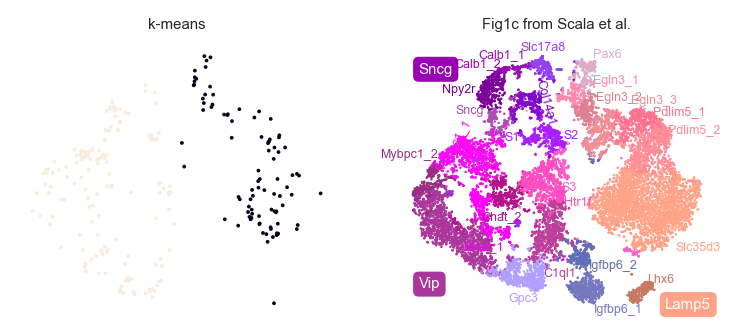

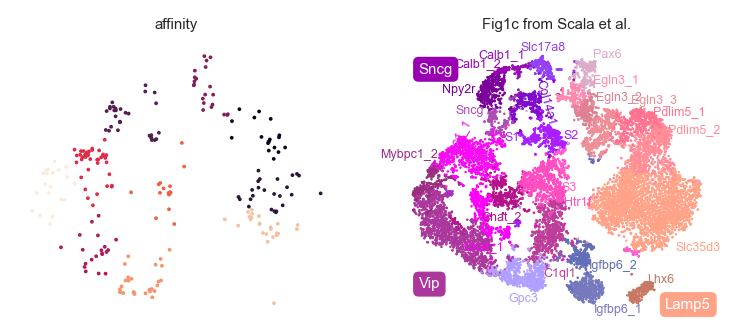

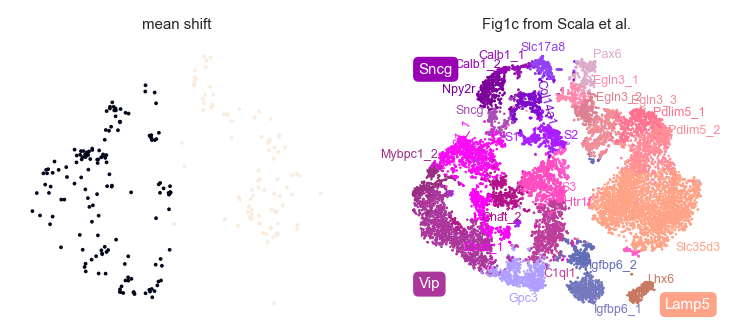

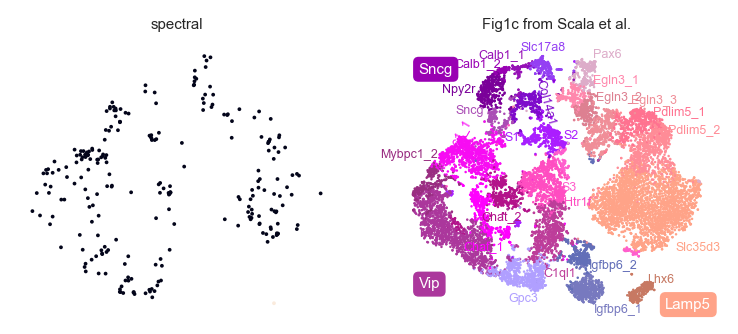

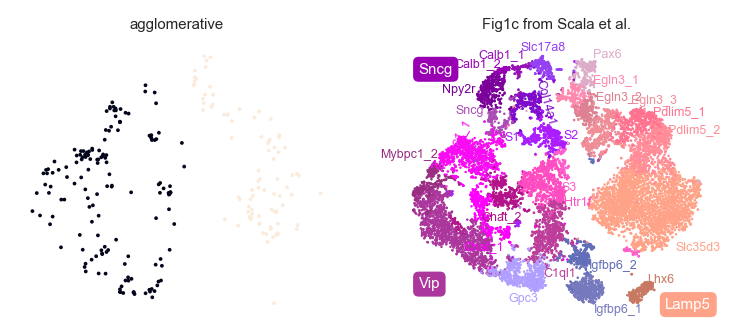

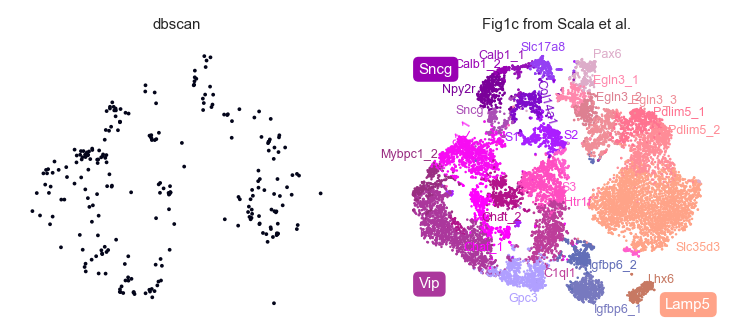

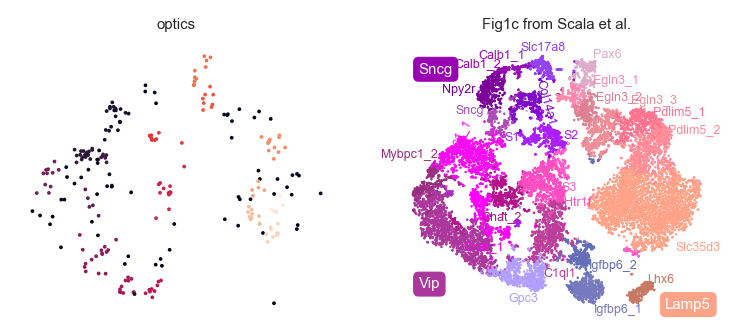

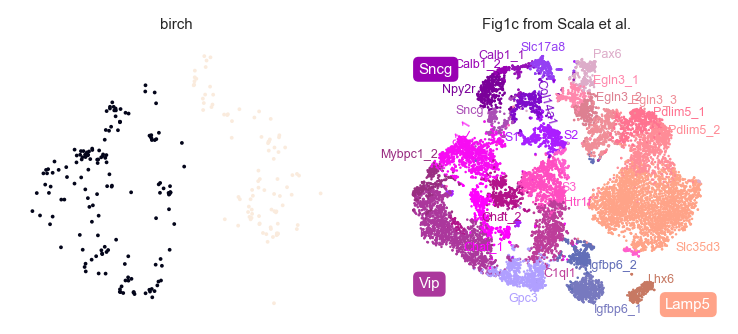

In [19]:
pred_scala, score_scala = print_results(model_dict_scala,true_labels=scala_family_codes, Z=Z, m1data=m1data)